In [1]:
!pip install -U numpy==1.19.5

In [1]:
import tushare as ts
import json
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

with open('token.json') as token_file:
    token = json.load(token_file)['token']

pro = ts.pro_api(token)

In [2]:
def get_daily(ts_code='', trade_date='', start_date='', end_date=''):
    for _ in range(3):
        try:
            if trade_date:
                df = pro.daily(ts_code=ts_code, trade_date=trade_date)
            else:
                df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
        except:
            time.sleep(1)
        else:
            return df

In [4]:
test_df = pro.daily(exchange='SSE',ts_code='689009.SH',start_date='20220104', end_date='20220210')
test_df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,689009.SH,20220210,61.80,62.20,61.10,61.51,61.51,0.00,0.0000,6035.78,37148.005
1,689009.SH,20220209,60.83,62.18,60.40,61.51,60.81,0.70,1.1511,12423.93,76250.056
2,689009.SH,20220208,60.80,61.60,59.07,60.81,61.33,-0.52,-0.8479,8239.31,49597.915
3,689009.SH,20220207,60.31,62.10,58.82,61.33,60.81,0.52,0.8551,15005.67,90778.007
4,689009.SH,20220128,60.65,61.06,59.60,60.81,60.60,0.21,0.3465,10422.22,63002.207


In [100]:
trade_date = pro.trade_cal(exchange='SSE', is_open='1',
                            start_date='20200101',
                            end_date='20220430',
                            fields='cal_date')

trade_date.head()

,cal_date
0,20200102
1,20200103
2,20200106
3,20200107
4,20200108


In [101]:
whole_df = pd.DataFrame()
for date in trade_date['cal_date'].values:
     df = get_daily(trade_date=date)
     whole_df = whole_df.append(df)

In [7]:
# whole_df.head(10)

In [4]:
stock1 = '600979.SH'
stock2 = '002642.SZ'

In [7]:
target_df = pro.daily(exchange='SSE',ts_code=stock1,start_date='20200104', end_date='20220430').sort_values('trade_date')

In [10]:
# target_df = whole_df[whole_df.ts_code == stock1].reset_index()

In [9]:
target_df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
560,600979.SH,20200106,4.23,4.29,4.23,4.26,4.26,0.00,0.0000,35324.37,15056.093
559,600979.SH,20200107,4.26,4.29,4.25,4.28,4.26,0.02,0.4695,29971.55,12791.987
558,600979.SH,20200108,4.27,4.28,4.20,4.20,4.28,-0.08,-1.8692,29090.10,12337.166
557,600979.SH,20200109,4.23,4.26,4.22,4.26,4.20,0.06,1.4286,29085.31,12347.515
556,600979.SH,20200110,4.26,4.26,4.23,4.24,4.26,-0.02,-0.4695,19300.00,8188.596


In [8]:
target_df.shape

(561, 11)

## Train test split

In [10]:
target_cols = list(target_df.columns)
target_cols.remove('close')
target_cols.remove('ts_code')
target_cols.remove('trade_date')
X = target_df[target_cols]
y = target_df.close

In [66]:
time_step = 5
X.iloc[0:time_step,0:10]

,open,high,low,pre_close,change,pct_chg,vol,amount
554,6.26,6.45,6.26,6.31,0.03,0.4754,87472.04,55614.939
553,6.34,6.58,6.32,6.34,0.19,2.9968,104871.16,67605.931
552,6.48,6.86,6.47,6.53,0.08,1.2251,178228.97,119423.922
551,6.65,6.94,6.65,6.61,0.33,4.9924,185866.76,127016.001
550,7.01,7.10,6.72,6.94,-0.19,-2.7378,155401.78,106640.368


In [67]:
X_list = []
y_list = []
for ii in range(time_step,len(target_df)):
    X_list.append(X.iloc[ii - time_step:ii,:])
    y_list.append(y.iloc[ii])

In [68]:
X = np.array(X_list)
y = np.array(y_list)
tscv = TimeSeriesSplit(n_splits=3)
all_splits = list(tscv.split(X, y))

In [129]:
X[:10]

array([[[ 6.26000000e+00,  6.45000000e+00,  6.26000000e+00,
          6.31000000e+00,  3.00000000e-02,  4.75400000e-01,
          8.74720400e+04,  5.56149390e+04],
        [ 6.34000000e+00,  6.58000000e+00,  6.32000000e+00,
          6.34000000e+00,  1.90000000e-01,  2.99680000e+00,
          1.04871160e+05,  6.76059310e+04],
        [ 6.48000000e+00,  6.86000000e+00,  6.47000000e+00,
          6.53000000e+00,  8.00000000e-02,  1.22510000e+00,
          1.78228970e+05,  1.19423922e+05],
        [ 6.65000000e+00,  6.94000000e+00,  6.65000000e+00,
          6.61000000e+00,  3.30000000e-01,  4.99240000e+00,
          1.85866760e+05,  1.27016001e+05],
        [ 7.01000000e+00,  7.10000000e+00,  6.72000000e+00,
          6.94000000e+00, -1.90000000e-01, -2.73780000e+00,
          1.55401780e+05,  1.06640368e+05]],

       [[ 6.34000000e+00,  6.58000000e+00,  6.32000000e+00,
          6.34000000e+00,  1.90000000e-01,  2.99680000e+00,
          1.04871160e+05,  6.76059310e+04],
        [ 6.48

In [130]:
y[0:10]

array([7.03, 7.33, 7.27, 7.2 , 7.5 , 7.88, 7.88, 7.49, 7.12, 6.76])

In [69]:
X.shape

(550, 5, 8)

### LSTM module

In [43]:
class LSTMModule():
    def __init__(self):
        self.batch_size=32
        self.input_shape = 5,8
        self.hidden_size = 50
        self.drop_out = 0.2
        self.output_size = 1
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(LSTM(self.hidden_size, return_sequences=True,input_shape=(self.input_shape)))
        model.add(LSTM(self.hidden_size, return_sequences=False))  # 如果上个lstm 不return sequences， 则不能使用
        model.add(Dropout(self.drop_out))
        model.add(Dense(self.output_size))
        model.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
        return model

In [94]:
lstm = LSTMModule()

In [72]:
lstm.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 50)             11800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [73]:
train1,test1 = all_splits[2]

In [95]:
history = lstm.model.fit(X[train1],y[train1],epochs=300)

Train on 413 samples
Epoch 1/300
413/413 [==============================] - 6s 14ms/sample - loss: 24.1429 - mae: 4.7451 - mape: 85.2612
Epoch 2/300
413/413 [==============================] - 0s 780us/sample - loss: 8.0043 - mae: 2.4678 - mape: 42.4145
Epoch 3/300
413/413 [==============================] - 0s 758us/sample - loss: 1.6775 - mae: 1.0497 - mape: 18.6543
Epoch 4/300
413/413 [==============================] - 0s 719us/sample - loss: 1.4172 - mae: 1.0156 - mape: 19.7413
Epoch 5/300
413/413 [==============================] - 0s 710us/sample - loss: 1.2811 - mae: 0.9639 - mape: 18.0518
Epoch 6/300
413/413 [==============================] - 0s 726us/sample - loss: 1.1807 - mae: 0.9094 - mape: 16.4762
Epoch 7/300
413/413 [==============================] - 0s 727us/sample - loss: 1.2305 - mae: 0.9325 - mape: 17.0315
Epoch 8/300
413/413 [==============================] - 0s 700us/sample - loss: 1.2410 - mae: 0.9359 - mape: 17.3389
Epoch 9/300
413/413 [==============================

In [23]:
from sklearn.metrics import mean_absolute_error

In [75]:
lstm.model.evaluate(X[test1],y[test1])

137/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.23273413525010547, 0.3749046, 6.252651]

In [96]:
original = y[test1]
pred = lstm.model.predict(X[test1])

In [97]:
mean_absolute_error(pred,original)

0.36069920324061044

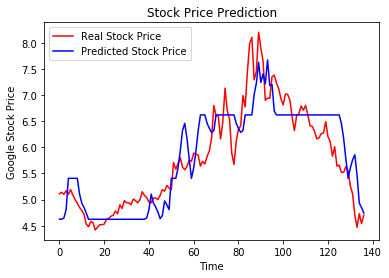

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

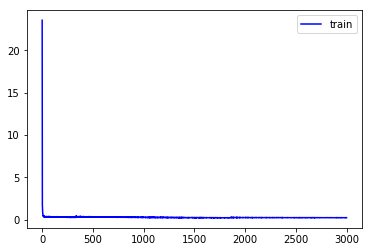

In [80]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='yellow',label='test')
plt.legend(["train","test"])
plt.show()

In [99]:
from sklearn.datasets import fetch_openml
bike_sharing = fetch_openml('Bike_Sharing_Demand', version=2, as_frame=True)
df = bike_sharing.frame

In [100]:
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,1.0


In [106]:
time_groups = ['year','month']
y_col = ['count']
add_col = ['temp','humidity']
bike_time = df[time_groups+add_col+y_col].groupby(time_groups).mean()

In [107]:
bike_time

temp  humidity       count
year month                                 
0.0  1.0     8.093924  0.574055   55.507267
     2.0    11.642989  0.559707   74.291217
     3.0    13.580548  0.570055   87.732877
     4.0    19.311627  0.668220  131.947149
     5.0    23.666478  0.713360  182.555108
     6.0    28.416417  0.593250  199.322222
     7.0    31.101586  0.589664  189.974462
     8.0    28.927715  0.625622  186.991792
     9.0    25.129512  0.783821  177.709902
     10.0   19.265034  0.706541  166.232840
     11.0   16.490097  0.675216  142.095967
     12.0   13.336896  0.649528  117.844804
1.0  1.0    11.275277  0.587314  130.558704
     2.0    12.932775  0.574249  149.041908
     3.0    18.430686  0.607712  221.904441
     4.0    19.230028  0.507897  242.651811
     5.0    25.106989  0.664556  263.259409
     6.0    27.679556  0.558361  281.708333
     7.0    30.846989  0.606089  273.665323
     8.0    29.183844  0.648629  288.310484
     9.0    25.423417  0.645375  303.573611
     10.0   20.718898  0.671596  280.848870
     11.0   13.782396  0.574805  212.623955
     12.0   13.244879  0.682682  166.729111

In [34]:
def get_xy(input_x, input_y, time_step):
    X_list = []
    y_list = []
    for ii in range(time_step,len(input_x)):
        X_list.append(input_x.iloc[ii - time_step:ii,:])
        y_list.append(input_y.iloc[ii])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

In [108]:
bike_time.shape

(24, 3)

In [126]:
X_bike,y_bike = get_xy(bike_time[add_col], bike_time[y_col],3)
tscv_bike = TimeSeriesSplit(n_splits=3)
all_splits_bike = list(tscv.split(X_bike, y_bike))
lstm_bike = LSTMModule()
lstm_bike.batch_size = 3
lstm_bike.input_shape = 3,2
train_i, test_i = all_splits_bike[2]
lstm_bike.model = lstm_bike.build_model()
history = lstm_bike.model.fit(X_bike[train_i],y_bike[train_i],epochs=30)

Train on 16 samples
Epoch 1/30
16/16 [==============================] - 5s 296ms/sample - loss: 39077.2227 - mae: 191.0000 - mape: 99.9459
Epoch 2/30
16/16 [==============================] - 0s 982us/sample - loss: 39035.7109 - mae: 190.9011 - mape: 99.8942
Epoch 3/30
16/16 [==============================] - 0s 1ms/sample - loss: 39012.7344 - mae: 190.8367 - mape: 99.8572
Epoch 4/30
16/16 [==============================] - 0s 1ms/sample - loss: 38964.3438 - mae: 190.7065 - mape: 99.7819
Epoch 5/30
16/16 [==============================] - 0s 1ms/sample - loss: 38942.8438 - mae: 190.6628 - mape: 99.7631
Epoch 6/30
16/16 [==============================] - 0s 1ms/sample - loss: 38893.6953 - mae: 190.5305 - mape: 99.6893
Epoch 7/30
16/16 [==============================] - 0s 1ms/sample - loss: 38849.7266 - mae: 190.4115 - mape: 99.6179
Epoch 8/30
16/16 [==============================] - 0s 1ms/sample - loss: 38833.8789 - mae: 190.3755 - mape: 99.6013
Epoch 9/30
16/16 [======================

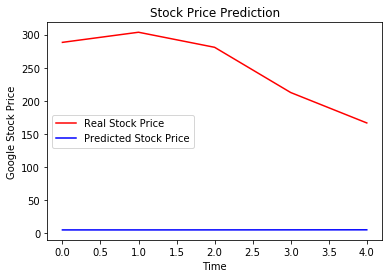

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(y_bike[test_i], color = 'red', label = 'Real Stock Price')
plt.plot(lstm_bike.model.predict(X_bike[test_i]), color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## 2 stocks test

In [8]:
stock1,stock2

('600979.SH', '002642.SZ')

In [102]:
target_df = whole_df[whole_df.ts_code.isin([stock1,stock2])].reset_index(drop=True)

In [103]:
target_df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002642.SZ,20200102,6.20,6.34,6.20,6.29,6.22,0.07,1.1254,74227.25,46586.696
1,600979.SH,20200102,4.22,4.24,4.19,4.24,4.19,0.05,1.1933,25991.00,10982.460
2,002642.SZ,20200103,6.27,6.33,6.20,6.31,6.29,0.02,0.3180,83564.51,52339.284
3,600979.SH,20200103,4.25,4.28,4.22,4.26,4.24,0.02,0.4717,37062.02,15733.614
4,002642.SZ,20200106,6.26,6.45,6.26,6.34,6.31,0.03,0.4754,87472.04,55614.939


In [41]:
target_df.pivot(index='trade_date',columns='ts_code').head()

close          
ts_code    002642.SZ 600979.SH
trade_date                    
20200106        6.34      4.26
20200107        6.53      4.28
20200108        6.61      4.20
20200109        6.94      4.26
20200110        6.75      4.24

In [105]:
target_df.pivot(index='trade_date',columns='ts_code').columns.to_flat_index()

Index([     ('open', '002642.SZ'),      ('open', '600979.SH'),
            ('high', '002642.SZ'),      ('high', '600979.SH'),
             ('low', '002642.SZ'),       ('low', '600979.SH'),
           ('close', '002642.SZ'),     ('close', '600979.SH'),
       ('pre_close', '002642.SZ'), ('pre_close', '600979.SH'),
          ('change', '002642.SZ'),    ('change', '600979.SH'),
         ('pct_chg', '002642.SZ'),   ('pct_chg', '600979.SH'),
             ('vol', '002642.SZ'),       ('vol', '600979.SH'),
          ('amount', '002642.SZ'),    ('amount', '600979.SH')],
      dtype='object')

In [42]:
stocks_df = target_df.pivot(index='trade_date',columns='ts_code')

In [43]:
stocks_df.columns = [a+'_'+b for a,b in stocks_df.columns.to_flat_index()]

In [30]:
stocks_df.head()

,open_002642.SZ,open_600979.SH,high_002642.SZ,high_600979.SH,low_002642.SZ,low_600979.SH,close_002642.SZ,close_600979.SH,pre_close_002642.SZ,pre_close_600979.SH,change_002642.SZ,change_600979.SH,pct_chg_002642.SZ,pct_chg_600979.SH,vol_002642.SZ,vol_600979.SH,amount_002642.SZ,amount_600979.SH
trade_date,,,,,,,,,,,,,,,,,,
20200106,6.26,4.23,6.45,4.29,6.26,4.23,6.34,4.26,6.31,4.26,0.03,0.00,0.4754,0.0000,87472.04,35324.37,55614.939,15056.093
20200107,6.34,4.26,6.58,4.29,6.32,4.25,6.53,4.28,6.34,4.26,0.19,0.02,2.9968,0.4695,104871.16,29971.55,67605.931,12791.987
20200108,6.48,4.27,6.86,4.28,6.47,4.20,6.61,4.20,6.53,4.28,0.08,-0.08,1.2251,-1.8692,178228.97,29090.10,119423.922,12337.166
20200109,6.65,4.23,6.94,4.26,6.65,4.22,6.94,4.26,6.61,4.20,0.33,0.06,4.9924,1.4286,185866.76,29085.31,127016.001,12347.515
20200110,7.01,4.26,7.10,4.26,6.72,4.23,6.75,4.24,6.94,4.26,-0.19,-0.02,-2.7378,-0.4695,155401.78,19300.00,106640.368,8188.596


In [109]:
stocks_df = stocks_df[10:] # rawdata issue, nan before no10

In [44]:
stocks_df.fillna(method='ffill',inplace=True) # rawdata missing item for several days. fill with last valid value

In [45]:
stocks_df.describe()

,close_002642.SZ,close_600979.SH
count,561.000000,561.000000
mean,5.586346,3.415294
std,1.008662,0.369909
min,3.770000,2.770000
25%,4.730000,3.100000
50%,5.390000,3.340000
75%,6.510000,3.640000
max,8.200000,4.510000


In [46]:
cols_x = [col for col in stocks_df.columns if 'open_' not in col]
cols_y = [col for col in stocks_df.columns if 'open_' in col]
X_stocks,y_stocks = get_xy(stocks_df[cols_x], stocks_df[cols_y],5)
split_ratio = 0.2
split_idx = -int(len(stocks_df)*split_ratio)

train_x, train_y = X_stocks[:split_idx], y_stocks[:split_idx]
test_x, test_y = X_stocks[split_idx:], y_stocks[split_idx:]

In [119]:
lstm_2stock = LSTMModule()
lstm_2stock.batch_size = 64
lstm_2stock.input_shape = 5,16
lstm_2stock.output_size = 2
lstm_2stock.model = lstm_2stock.build_model()
history_2stock = lstm_2stock.model.fit(train_x, train_y,epochs=300)

Train on 446 samples
Epoch 1/300
446/446 [==============================] - 6s 13ms/sample - loss: 18.4359 - mae: 4.0760 - mape: 90.9424
Epoch 2/300
446/446 [==============================] - 0s 715us/sample - loss: 10.4741 - mae: 2.9629 - mape: 64.9605
Epoch 3/300
446/446 [==============================] - 0s 800us/sample - loss: 2.0706 - mae: 1.1189 - mape: 23.9291
Epoch 4/300
446/446 [==============================] - 0s 789us/sample - loss: 0.9996 - mae: 0.7991 - mape: 19.3627
Epoch 5/300
446/446 [==============================] - 0s 746us/sample - loss: 0.7272 - mae: 0.6852 - mape: 15.7912
Epoch 6/300
446/446 [==============================] - 0s 920us/sample - loss: 0.6250 - mae: 0.6256 - mape: 14.2484
Epoch 7/300
446/446 [==============================] - 0s 1ms/sample - loss: 0.5391 - mae: 0.5792 - mape: 13.1937
Epoch 8/300
446/446 [==============================] - 0s 822us/sample - loss: 0.5107 - mae: 0.5697 - mape: 13.1235
Epoch 9/300
446/446 [==============================]

In [120]:
y_pred = lstm_2stock.model.predict(test_x)

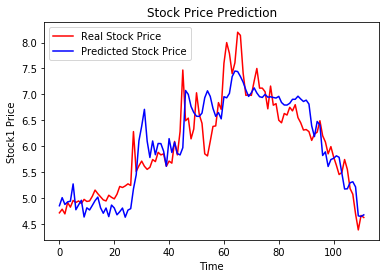

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(test_y[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(y_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock1 Price')
plt.legend()
plt.show()

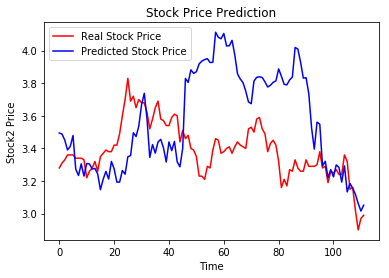

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(test_y[:,1], color = 'red', label = 'Real Stock Price')
plt.plot(y_pred[:,1], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock2 Price')
plt.legend()
plt.show()

In [215]:
sh_list = [tscode for tscode in whole_df.ts_code.unique() if ('SH' in tscode) & ('688' != tscode[:3])]
sz_list = [tscode for tscode in whole_df.ts_code.unique() if ('SZ' in tscode) & ('300' != tscode[:3])]
bj_list = [tscode for tscode in whole_df.ts_code.unique() if 'BJ' in tscode]

In [192]:
import random
random.seed(950925)

In [20]:
# sh5 = random.sample(sh_list,5)
sh5=['600812.SH','603053.SH'], '600609.SH']

SyntaxError: invalid syntax (<ipython-input-20-ac6ec1b54747>, line 2)

In [216]:
sz5 = random.sample(sz_list,5)
bj5 = random.sample(bj_list,5)

In [21]:
def prepare_data(df, tscode_list):
    target_df = df[df.ts_code.isin(tscode_list)].reset_index(drop=True)
    stocks_df = target_df.pivot(index='trade_date',columns='ts_code')
    stocks_df.columns = [a+'_'+b for a,b in stocks_df.columns.to_flat_index()]
    stocks_df.fillna(method='ffill',inplace=True)
    cols_x = [col for col in stocks_df.columns if 'open_' not in col]
    cols_y = [col for col in stocks_df.columns if 'open_' in col]
    X_stocks,y_stocks = get_xy(stocks_df[cols_x], stocks_df[cols_y],5)
    split_ratio = 0.2
    split_idx = -int(len(stocks_df)*split_ratio)

    train_x, train_y = X_stocks[:split_idx], y_stocks[:split_idx]
    test_x, test_y = X_stocks[split_idx:], y_stocks[split_idx:]
    return train_x, train_y, test_x, test_y

In [22]:
train_sh5_x, train_sh5_y, test_sh5_x, test_sh5_y = prepare_data(whole_df, sz5)

NameError: name 'whole_df' is not defined

In [218]:
# whole_df[whole_df.ts_code.isin(bj5)].pivot(index='trade_date',columns='ts_code')

open                                              high  \
ts_code    430047.BJ 831768.BJ 835640.BJ 836433.BJ 837344.BJ 430047.BJ   
trade_date                                                               
20211115       18.12     17.81     27.20       NaN     27.70     21.68   
20211116       17.50     15.20     27.25       NaN     26.90     17.80   
20211117       16.50     14.40     23.65      8.93     25.35     16.50   
20211118       14.60     14.45     23.98      9.00     25.81     14.61   
20211119       14.00     14.19     23.65      8.93     25.63     15.42   
...              ...       ...       ...       ...       ...       ...   
20220425       12.13      7.66     13.50      6.29     15.88     12.32   
20220426       11.40      7.55     13.20      6.20     15.35     11.48   
20220427       10.26      6.50     13.00      5.86     15.25     10.80   
20220428       10.66      6.13     13.63      6.60     15.89     10.66   
20220429       10.13      6.10     13.00      6.84     15.45     10.75   

                                                    ...       vol            \
ts_code    831768.BJ 835640.BJ 836433.BJ 837344.BJ  ... 430047.BJ 831768.BJ   
trade_date                                          ...                       
20211115       17.95     30.60       NaN     31.72  ...  97922.84  36583.67   
20211116       15.60     27.25       NaN     26.90  ...  35144.43  22745.44   
20211117       14.68     24.25      9.10     26.50  ...  71191.30   9278.65   
20211118       14.59     24.58      9.18     26.28  ...  41947.28   6119.86   
20211119       14.28     23.95      8.93     25.90  ...  45359.15  10840.31   
...              ...       ...       ...       ...  ...       ...       ...   
20220425        7.77     13.88      6.29     15.88  ...  13965.74   3349.81   
20220426        7.55     13.40      6.20     16.29  ...  11150.31   2882.83   
20220427        6.50     13.57      6.04     16.08  ...  11423.33  14454.87   
20220428        6.22     13.63      7.14     15.94  ...   7646.07   4275.87   
20220429        6.19     14.33      7.10     18.48  ...   6828.59   3499.18   

                                              amount                         \
ts_code    835640.BJ 836433.BJ 837344.BJ   430047.BJ  831768.BJ   835640.BJ   
trade_date                                                                    
20211115    62385.57       NaN  30638.27  178722.467  59406.168  173390.847   
20211116    28240.23       NaN  10199.01   60011.282  32895.897   70363.492   
20211117    18558.63   5237.20   5529.35  107959.332  13354.681   43354.268   
20211118     8284.11   5275.06   4583.90   59129.944   8686.489   19912.836   
20211119    10355.13   7207.45   3694.87   65456.231  14686.855   23950.031   
...              ...       ...       ...         ...        ...         ...   
20220425     4023.70   6174.96    944.20   16288.582   2480.738    5426.962   
20220426     3949.02   4390.26    941.89   12056.842   2077.591    5215.008   
20220427     3078.99   2683.39    660.24   11780.639   8840.532    4075.371   
20220428     1733.63  24751.24   1209.69    7980.984   2595.196    2275.597   
20220429     5385.64  11645.16   4278.72    7205.702   2130.129    7468.257   

                                  
ts_code     836433.BJ  837344.BJ  
trade_date                        
20211115          NaN  86865.763  
20211116          NaN  26302.465  
20211117     4691.080  14270.667  
20211118     4751.300  11739.949  
20211119     6246.191   9281.812  
...               ...        ...  
20220425     3703.072   1472.480  
20220426     2592.689   1474.044  
20220427     1585.591   1030.617  
20220428    16741.180   1893.788  
20220429     8082.824   7373.112  

[112 rows x 45 columns]

In [220]:
lstm_5stock = LSTMModule()
lstm_5stock.batch_size = 32
lstm_5stock.input_shape = 5,train_sh5_x.shape[2]
lstm_5stock.output_size = train_sh5_y.shape[1]
lstm_5stock.model = lstm_5stock.build_model()
history_5stock = lstm_5stock.model.fit(train_sh5_x, train_sh5_y,epochs=300)

Train on 446 samples
Epoch 1/300
446/446 [==============================] - 5s 12ms/sample - loss: 57.8171 - mae: 7.1389 - mape: 100.1385
Epoch 2/300
446/446 [==============================] - 0s 925us/sample - loss: 50.3634 - mae: 6.6657 - mape: 94.0996
Epoch 3/300
446/446 [==============================] - 0s 871us/sample - loss: 36.4573 - mae: 5.6311 - mape: 80.4655
Epoch 4/300
446/446 [==============================] - 0s 945us/sample - loss: 19.4615 - mae: 3.9534 - mape: 56.9522
Epoch 5/300
446/446 [==============================] - 0s 902us/sample - loss: 9.3187 - mae: 2.5509 - mape: 36.3854
Epoch 6/300
446/446 [==============================] - 0s 946us/sample - loss: 5.0753 - mae: 1.7366 - mape: 24.0413
Epoch 7/300
446/446 [==============================] - 0s 930us/sample - loss: 3.7666 - mae: 1.4236 - mape: 19.4787
Epoch 8/300
446/446 [==============================] - 1s 1ms/sample - loss: 3.0177 - mae: 1.2488 - mape: 17.3940
Epoch 9/300
446/446 [============================

In [221]:
y_pred_sh5 = lstm_5stock.model.predict(test_sh5_x)

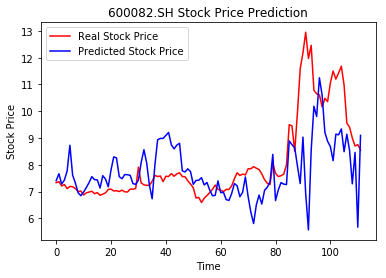

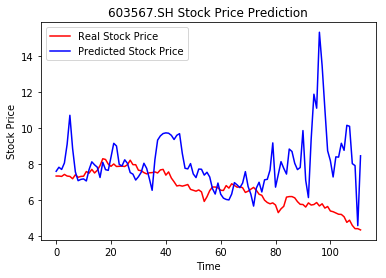

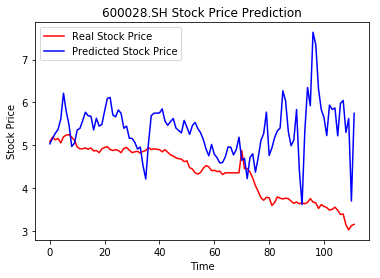

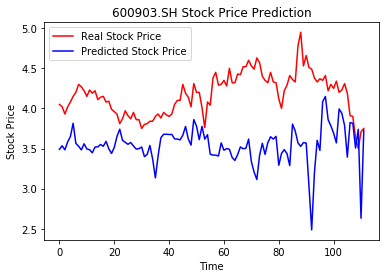

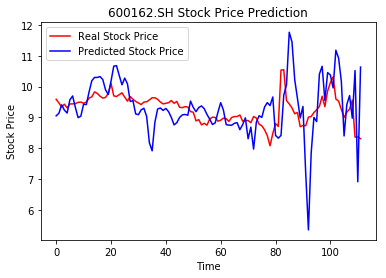

In [222]:
%matplotlib inline
# fig,ax = plt.subplots(5,1)
for idx, ts_code in enumerate(sh5):
    plt.plot(test_sh5_y[:,idx], color = 'red', label = 'Real Stock Price')
    # ax[idx].plot(test_sh5_y[:,idx], color = 'red', label = 'Real Stock Price')
    # ax[idx].plot(y_pred_sh5[:,idx], color = 'blue', label = 'Predicted Stock Price')
    plt.plot(y_pred_sh5[:,idx], color = 'blue', label = 'Predicted Stock Price')
    plt.title('%s Stock Price Prediction' %  ts_code)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

XGboost

In [3]:
from xgboost import XGBRegressor
xg = XGBRegressor()

In [228]:
xg.fit(X[:500],y[:500])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [229]:
check = pd.DataFrame(data={'true':y[500:],'pred':xg.predict(X[500:])})

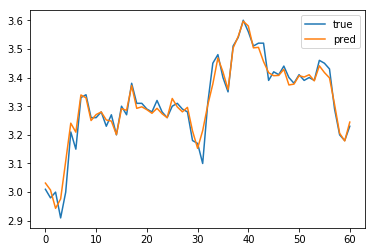

In [230]:
%matplotlib inline
check.plot()

In [231]:
xg.score(X[550:],y[550:])

0.8957515944755423

In [232]:
xg.feature_names_in_

array(['open', 'high', 'low', 'pre_close', 'change', 'pct_chg', 'vol',
       'amount'], dtype='<U9')

In [233]:
xg.feature_importances_

array([0.00060779, 0.52977294, 0.45937386, 0.00407753, 0.00090963,
       0.00359547, 0.00063815, 0.00102466], dtype=float32)

## 2 Stocks test - open predict close

In [60]:
target_df = pd.DataFrame()
for scode in [stock1,stock2]:
    temp_df = pro.daily(exchange='SSE',ts_code=scode,start_date='20200104', end_date='20220430').sort_values('trade_date')
    target_df = target_df.append(temp_df)

In [61]:
target_df = target_df[['ts_code','trade_date','open','close']]

In [62]:
stocks_df = target_df.pivot(index='trade_date',columns='ts_code')
stocks_df.columns = [a+'_'+b for a,b in stocks_df.columns.to_flat_index()]
stocks_df.fillna(method='ffill',inplace=True)

In [63]:
cols_x = [col for col in stocks_df.columns if 'close_' not in col]
cols_y = [col for col in stocks_df.columns if 'close_' in col]
X_stocks,y_stocks = stocks_df[cols_x], stocks_df[cols_y]
split_ratio = 0.2
split_idx = -int(len(stocks_df)*split_ratio)

train_x, train_y = X_stocks[:split_idx], y_stocks[:split_idx]
test_x, test_y = X_stocks[split_idx:], y_stocks[split_idx:]

In [66]:
%matplotlib inline

xg = XGBRegressor()
xg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [90]:
pred = pd.DataFrame(xg.predict(test_x))
print(xg.score(test_x, test_y))

0.8309710201176901


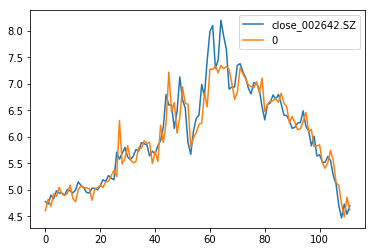

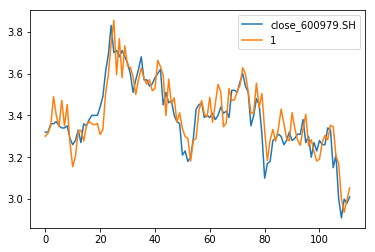

In [95]:
for idx,txt in enumerate(test_x.columns):
    check = pd.concat([test_y.iloc[:,idx].reset_index(drop=True), pred.iloc[:,idx]], axis=1)
    check.plot()

## 2 stocks lag with time window - open predict close

In [152]:
time_window = 1
cols_x = [col for col in stocks_df.columns if 'close_' not in col]
cols_y = [col for col in stocks_df.columns if 'close_' in col]
X_stocks,y_stocks = get_xy(stocks_df[cols_x], stocks_df[cols_y],time_window)
split_ratio = 0.2
split_idx = -int(len(stocks_df)*split_ratio)

train_x, train_y = X_stocks[:split_idx].reshape(-1,time_window*2), y_stocks[:split_idx]
test_x, test_y = X_stocks[split_idx:].reshape(-1,time_window*2), y_stocks[split_idx:]

In [153]:
%matplotlib inline

xg = XGBRegressor()
xg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [154]:
pred = xg.predict(test_x)
print(xg.score(test_x, test_y))

0.6725964221733276


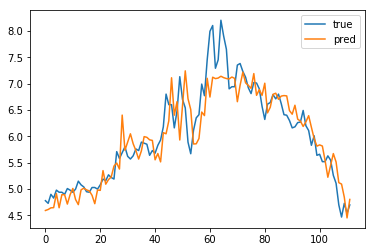

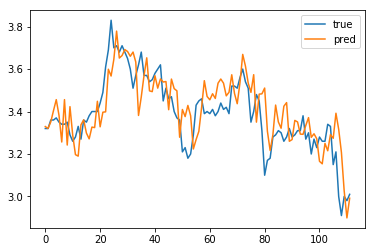

In [155]:
for idx in [0,1]:
    check = pd.DataFrame(data={'true':test_y[:,idx], 'pred':pred[:,idx]})
    check.plot()

## 2 stocks open+vol predict close
- vol:0.79
- change: 0.94
- pct_chg: 0.94
- amount: 0.79
- change only, -open: -2.9

In [242]:
target_df = pd.DataFrame()
for scode in [stock1,stock2]:
    temp_df = pro.daily(exchange='SSE',ts_code=scode,start_date='20200104', end_date='20220430').sort_values('trade_date')
    target_df = target_df.append(temp_df)

In [243]:
target_df = target_df[['ts_code','trade_date','open','change','close']]

In [244]:
stocks_df = target_df.pivot(index='trade_date',columns='ts_code')
stocks_df.columns = [a+'_'+b for a,b in stocks_df.columns.to_flat_index()]
stocks_df.fillna(method='ffill',inplace=True)

In [245]:
cols_x = [col for col in stocks_df.columns if 'close_' not in col]
cols_y = [col for col in stocks_df.columns if 'close_' in col]
X_stocks,y_stocks = stocks_df[cols_x], stocks_df[cols_y]
split_ratio = 0.2
split_idx = -int(len(stocks_df)*split_ratio)

train_x, train_y = X_stocks[:split_idx], y_stocks[:split_idx]
test_x, test_y = X_stocks[split_idx:], y_stocks[split_idx:]

In [246]:
%matplotlib inline

xg = XGBRegressor()
xg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [247]:
pred = pd.DataFrame(xg.predict(test_x))
print(xg.score(test_x, test_y))

0.9473525263860225


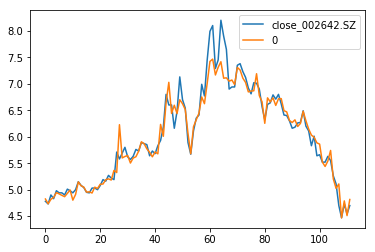

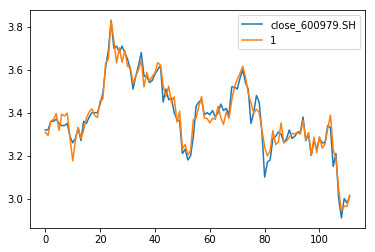

In [250]:
for idx in [0,1]:
    check = pd.concat([test_y.iloc[:,idx].reset_index(drop=True), pred.iloc[:,idx]], axis=1)
    check.plot()

In [251]:
xg.feature_importances_

array([0.8077334 , 0.17309532, 0.01366432, 0.00550692], dtype=float32)

In [252]:
xg.feature_names_in_

array(['open_002642.SZ', 'open_600979.SH', 'change_002642.SZ',
       'change_600979.SH'], dtype='<U16')

## 2 stocks lag with time window - open,vol predict close

In [195]:
time_window = 2
cols_x = [col for col in stocks_df.columns if 'close_' not in col]
cols_y = [col for col in stocks_df.columns if 'close_' in col]
X_stocks,y_stocks = get_xy(stocks_df[cols_x], stocks_df[cols_y],time_window)
split_ratio = 0.2
split_idx = -int(len(stocks_df)*split_ratio)

train_x, train_y = X_stocks[:split_idx].reshape(-1,time_window*len(cols_x)), y_stocks[:split_idx]
test_x, test_y = X_stocks[split_idx:].reshape(-1,time_window*len(cols_x)), y_stocks[split_idx:]

In [196]:
%matplotlib inline

xg = XGBRegressor()
xg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [197]:
pred = xg.predict(test_x)
print(xg.score(test_x, test_y))

0.7527164931092287


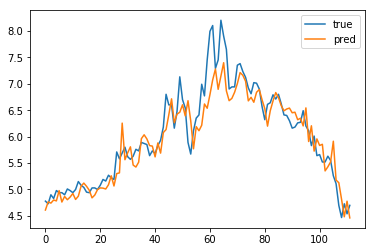

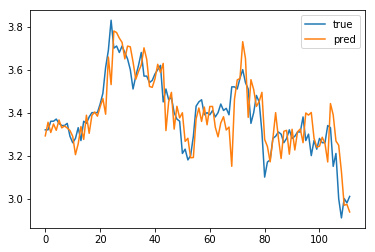

In [198]:
for idx in [0,1]:
    check = pd.DataFrame(data={'true':test_y[:,idx], 'pred':pred[:,idx]})
    check.plot()

In [227]:
xg.feature_names_in_

array(['open_002642.SZ', 'open_600979.SH', 'amount_002642.SZ',
       'amount_600979.SH'], dtype='<U16')

In [226]:
xg.feature_importances_

array([0.79308575, 0.19427983, 0.00625591, 0.00637852], dtype=float32)

### arima 需要p,q 值

In [257]:
from statsmodels.tsa.arima.model import ARIMA

In [255]:
train_y.iloc[:,0]

trade_date
20200106    6.34
20200107    6.53
20200108    6.61
20200109    6.94
20200110    6.75
            ... 
20211108    4.53
20211109    4.62
20211110    4.64
20211111    4.68
20211112    4.70
Name: close_002642.SZ, Length: 449, dtype: float64

In [259]:
model = ARIMA(train_y.iloc[:,0], (1,1,1)).fit()

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

In [261]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(train_y.iloc[:,0],order= (1,1,1)).fit()

/Users/nanzou/anaconda3/envs/learn_notes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nanzou/anaconda3/envs/learn_notes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nanzou/anaconda3/envs/learn_notes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [264]:
model.forecast(len(test_y))

/Users/nanzou/anaconda3/envs/learn_notes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


449    4.700738
450    4.700590
451    4.700619
452    4.700613
453    4.700614
         ...   
556    4.700614
557    4.700614
558    4.700614
559    4.700614
560    4.700614
Name: predicted_mean, Length: 112, dtype: float64

/Users/nanzou/anaconda3/envs/learn_notes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


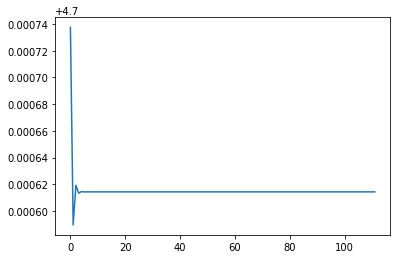

In [271]:

model.forecast(len(test_y)).reset_index(drop=True).plot()

## 测试纯change 多window 1，5，10

In [279]:
target_df = pd.DataFrame()
for scode in [stock1,stock2]:
    temp_df = pro.daily(exchange='SSE',ts_code=scode,start_date='20200104', end_date='20220430').sort_values('trade_date')
    target_df = target_df.append(temp_df)

In [280]:
target_df = target_df[['ts_code','trade_date','change','close']]

In [281]:
stocks_df = target_df.pivot(index='trade_date',columns='ts_code')
stocks_df.columns = [a+'_'+b for a,b in stocks_df.columns.to_flat_index()]
stocks_df.fillna(method='ffill',inplace=True)

In [372]:
x_temp = np.ones((len(stocks_df),1))

for time_window in [1,5,10]:
    cols_x = [col for col in stocks_df.columns if 'close_' not in col]
    cols_y = [col for col in stocks_df.columns if 'close_' in col]
    X_stocks,y_stocks = get_xy(stocks_df[cols_x], stocks_df[cols_y],time_window)
    X_stocks = X_stocks.reshape(-1,time_window*2)
    x_temp = np.concatenate((x_temp[-len(X_stocks):],X_stocks), axis=1)

y_temp = y_stocks[-len(x_temp):]

In [374]:
split_ratio = 0.2
split_idx = -int(len(x_temp)*split_ratio)

train_x, train_y = x_temp[:split_idx], y_temp[:split_idx]
test_x, test_y = x_temp[split_idx:], y_temp[split_idx:]

In [375]:
%matplotlib inline

xg = XGBRegressor()
xg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [376]:
pred = xg.predict(test_x)
print(xg.score(test_x, test_y))

-1.6775189632952552


In [378]:
test_x

array([[ 1.  , -0.05,  0.  , ...,  0.03, -0.05,  0.  ],
       [ 1.  ,  0.17,  0.04, ...,  0.  ,  0.17,  0.04],
       [ 1.  , -0.07,  0.  , ...,  0.04, -0.07,  0.  ],
       ...,
       [ 1.  , -0.23, -0.09, ..., -0.21, -0.23, -0.09],
       [ 1.  ,  0.26,  0.09, ..., -0.09,  0.26,  0.09],
       [ 1.  , -0.19, -0.02, ...,  0.09, -0.19, -0.02]])

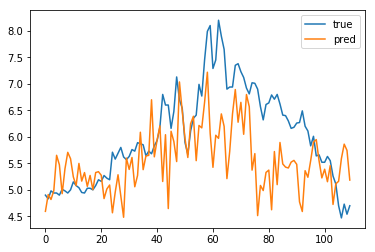

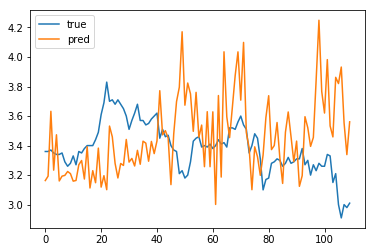

In [379]:
for idx in [0,1]:
    check = pd.DataFrame(data={'true':test_y[:,idx], 'pred':pred[:,idx]})
    check.plot()

In [227]:
xg.feature_names_in_

array(['open_002642.SZ', 'open_600979.SH', 'amount_002642.SZ',
       'amount_600979.SH'], dtype='<U16')

In [226]:
xg.feature_importances_

array([0.79308575, 0.19427983, 0.00625591, 0.00637852], dtype=float32)